In [1]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

/home/ubuntu/anaconda3/envs/dgl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=20, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

In [3]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,1217,289,1
1,1648,8782,0
2,596,8131,0
3,475,57,1
4,1450,4349,0
...,...,...,...
42341,1778,4743,0
42342,519,4,1
42343,1487,2879,1
42344,1115,36,1


In [4]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

In [5]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [6]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)

full graph average sampling time: 0.15833180291312082
device:  cuda


In [15]:
# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

[Epoch 1]train_loss:  1.0071888744437099
[Epoch 1]test_loss:  0.8984044815009495
[Epoch 2]train_loss:  0.7994302792071846
[Epoch 2]test_loss:  0.7487996238582539
[Epoch 3]train_loss:  0.7098590814920953
[Epoch 3]test_loss:  0.7074941434950198
[Epoch 4]train_loss:  0.6923522641908684
[Epoch 4]test_loss:  0.6997482814878787
[Epoch 5]train_loss:  0.6885819659129531
[Epoch 5]test_loss:  0.6973770463241721
[Epoch 6]train_loss:  0.6863896460100882
[Epoch 6]test_loss:  0.6959516556757801
[Epoch 7]train_loss:  0.684163830154228
[Epoch 7]test_loss:  0.6947241933840625
[Epoch 8]train_loss:  0.6812128748276867
[Epoch 8]test_loss:  0.6932618773208474
[Epoch 9]train_loss:  0.6761404396904539
[Epoch 9]test_loss:  0.6903589430845009
[Epoch 10]train_loss:  0.6653680456934165
[Epoch 10]test_loss:  0.6818760691948657
[Epoch 11]train_loss:  0.6392908626507767
[Epoch 11]test_loss:  0.65512552576245
[Epoch 12]train_loss:  0.5823213146811279
[Epoch 12]test_loss:  0.5991363011441141
[Epoch 13]train_loss:  0.

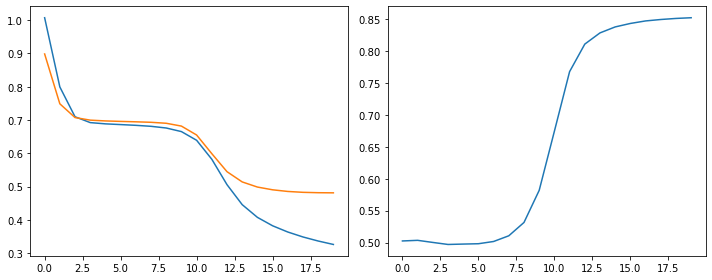

In [16]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)

plt.tight_layout()

In [30]:
data_loader = DataLoader('movie')
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()

# train test split
x_train, x_test, y_train, y_test = train_test_split(
    df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)

Construct knowledge graph ... Done
Build dataset dataframe ... Done


In [8]:
df_dataset

,userID,itemID,label
0,602,3,1
1,314,2,1
2,8404,29949,0
3,462,3,1
4,12826,2,1
...,...,...,...
14947307,7348,4,1
14947308,721,0,1
14947309,90,2,1
14947310,249,2,1


In [9]:
x_train

,userID,itemID,label
0,602,3,1
1,314,2,1
2,8404,29949,0
3,462,3,1
4,12826,2,1
...,...,...,...
11957844,133,2,1
11957845,586,1,1
11957846,3117,3,1
11957847,476,2,1


In [10]:
x_test

,userID,itemID,label
11957849,18,1,1
11957850,1474,3,1
11957851,0,3,1
11957852,1149,4,1
11957853,3098,3,1
...,...,...,...
14947307,7348,4,1
14947308,721,0,1
14947309,90,2,1
14947310,249,2,1


In [11]:
x_test.iloc[0]

userID    18
itemID     1
label      1
Name: 11957849, dtype: int64

In [12]:
x_test.reset_index(inplace=True, drop=True)

In [13]:
x_test

,userID,itemID,label
0,18,1,1
1,1474,3,1
2,0,3,1
3,1149,4,1
4,3098,3,1
...,...,...,...
2989458,7348,4,1
2989459,721,0,1
2989460,90,2,1
2989461,249,2,1


In [15]:
device = 'cuda'
userID = torch.tensor(df_dataset['userID']).to(device)
itemID = torch.tensor(df_dataset['itemID']).to(device)
labels = torch.tensor(df_dataset['label'], dtype=torch.float32).to(device)

In [28]:
from gs.utils import SeedGenerator
batch_size = 65535
train_seedloader = SeedGenerator(
        torch.tensor(x_train.index), batch_size=batch_size, shuffle=True, drop_last=False)
test_seedloader = SeedGenerator(
    torch.tensor(x_test.index), batch_size=batch_size, shuffle=True, drop_last=False)

In [17]:
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=2e-2,
                        weight_decay=1e-7)

In [29]:
print(len(train_seedloader))

11957849


In [31]:
from tqdm import tqdm
# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(1):
    running_loss = 0.0
    for i, seeds in enumerate(tqdm(train_seedloader)):
        user_ids, item_ids, batch_labels = userID[seeds], itemID[seeds], labels[seeds]
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, batch_labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    # print train loss per every epoch
    loss_list.append(running_loss / len(train_seedloader))

    # evaluate per every epoch
    test_loss = 0
    total_roc = 0
    with torch.no_grad():
        for i, seeds in enumerate(tqdm(test_seedloader)):
            user_ids, item_ids, batch_labels = userID[seeds], itemID[seeds], labels[seeds]
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, batch_labels).item()
            total_roc += roc_auc_score(batch_labels.cpu().detach().numpy(),
                                        outputs.cpu().detach().numpy())
    test_loss_list.append(test_loss / len(test_seedloader))
    auc_score_list.append(total_roc / len(test_seedloader))

    print('[Epoch {}]train_loss: '.format(epoch+1),
            running_loss / len(train_seedloader), 'test_loss: ', test_loss / len(test_seedloader), 'auc: ', total_roc / len(test_seedloader))


  0%|          | 46/2989463 [00:01<18:54:28, 43.92it/s]

[Epoch 1]train_loss:  2.1087242856853977e-08 test_loss:  1.6355582699338033e-08 auc:  1.5387378695068678e-05
